In [1]:
from pathlib import Path 
import pandas as pd
import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns 
from feature_creation import (
    config, 
    csv_preprocess, 
    make_windowed_features,
    read_hdf,
    update_hdf
)

In [2]:
dfraw = read_hdf()

In [3]:
Xy = pd.DataFrame()
for name, training_set in tqdm.tqdm(dfraw.groupby('name')):
    y = training_set['y'].iloc[0]
    xy = make_windowed_features(training_set)
    xy['y'] = y
    Xy = pd.concat([Xy, xy], ignore_index=True)

100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


In [7]:
Xy

,pkt_entropy,up_pkt_entropy,dw_pkt_entropy,up_speed,dw_speed,net_updown,div_updown,div_updown_var,up_pkt_var,dw_pkt_var,...,jitter,num_unique_ips,tcp_nports,udp_nports,tcp_seq,tcp_ack,tcp_flags,ttl_entropy,ack_entropy,y
0,1.185396,2.401628,0.332824,5671.8,369941.3,-3642695.0,0.015332,1.322942,48778.610459,36871.305181,...,0.001198,8.0,14.0,11.0,17.0,17.0,3.0,0.657901,0.076235,1
1,1.335258,2.635921,0.513056,2112.4,110044.0,-1079316.0,0.019196,3.078863,189930.977725,61688.683154,...,0.009629,8.0,14.0,10.0,20.0,19.0,3.0,0.849822,0.265804,1
2,1.179323,2.479903,0.376044,8234.7,390994.1,-3827594.0,0.021061,9.098807,392570.313743,43145.251123,...,0.001410,9.0,19.0,10.0,50.0,48.0,4.0,0.758228,0.263617,1
3,1.157359,2.569506,0.362024,793.0,98131.2,-973382.0,0.008081,0.060052,3050.407701,50795.992541,...,0.005663,8.0,20.0,8.0,20.0,20.0,3.0,0.740902,0.262502,1
4,1.068526,2.574193,0.268420,730.5,92244.0,-915135.0,0.007919,0.075831,2499.737771,32964.626435,...,0.017007,7.0,16.0,8.0,15.0,15.0,3.0,0.623772,0.193818,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,4.596754,3.736763,4.089782,2305.6,1411.8,8938.0,1.633093,1.415775,327028.469935,230989.052632,...,0.177489,7.0,16.0,10.0,14.0,14.0,3.0,1.759899,1.172111,1
895,4.810255,4.142095,4.260093,1310.4,1204.5,1059.0,1.087920,1.266802,212720.099668,167918.936047,...,0.135339,6.0,8.0,12.0,12.0,11.0,3.0,1.733618,1.333063,1
896,4.467344,3.784368,3.868182,1022.0,1044.9,-229.0,0.978084,1.202664,238624.559140,198413.320690,...,0.314474,6.0,12.0,8.0,17.0,16.0,3.0,1.959408,2.297287,1
897,4.500092,3.657708,4.240965,2230.7,1886.8,3439.0,1.182266,1.327227,283036.717707,213254.192308,...,0.083565,11.0,17.0,14.0,16.0,16.0,4.0,1.614174,1.141040,1


AttributeError: Rectangle.set() got an unexpected keyword argument 'nbins'

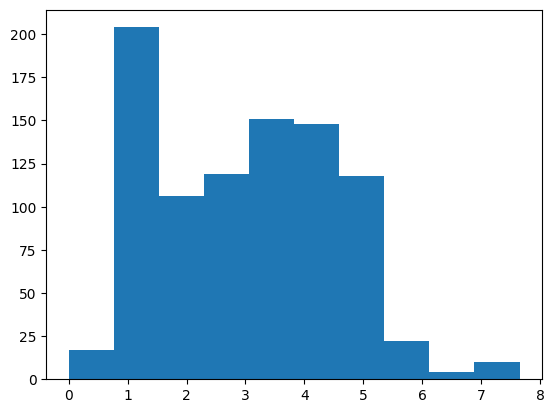

In [6]:
Xy.pkt_entropy.hist(nbins=30)

In [26]:
training_set.time = pd.to_datetime(training_set.time, unit='s')
training_set.set_index('time')
training_set.sort_index(inplace=True)

In [28]:
training_set

,packet_size,tcp_sport,tcp_dport,udp_sport,udp_dport,time,identification,ttl,tcp_seq,tcp_ack,client,server,updown,tcp_flag,y,name
time,,,,,,,,,,,,,,,,
1970-01-01 00:00:01.726173994,53,-1,-1,443,52949,2024-09-12 20:46:34.984654903,0,59,-1,-1,192.168.0.100,142.250.218.234,-1,0,1,insta_packets_01
1970-01-01 00:00:01.726173995,52,443,60012,-1,-1,2024-09-12 20:46:35.930421114,64860,50,1510056115,2130456722,192.168.0.100,200.198.193.226,-1,1,1,insta_packets_01
1970-01-01 00:00:01.726173995,52,60012,443,-1,-1,2024-09-12 20:46:35.930438042,13904,64,2130456722,1510056116,192.168.0.100,200.198.193.226,1,1,1,insta_packets_01
1970-01-01 00:00:01.726173996,2043,44424,443,-1,-1,2024-09-12 20:46:36.033946991,8536,64,2272005836,1111288527,192.168.0.100,57.144.136.145,1,2,1,insta_packets_01
1970-01-01 00:00:01.726173996,52,443,44424,-1,-1,2024-09-12 20:46:36.066585064,27621,52,1111288527,2272007827,192.168.0.100,57.144.136.145,-1,1,1,insta_packets_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:01.726174322,1260,-1,-1,443,42532,2024-09-12 20:52:02.109743118,1,91,-1,-1,192.168.0.100,187.86.252.32,-1,0,1,insta_packets_01
1970-01-01 00:00:01.726174322,1260,-1,-1,443,42532,2024-09-12 20:52:02.109743118,2,91,-1,-1,192.168.0.100,187.86.252.32,-1,0,1,insta_packets_01
1970-01-01 00:00:01.726174322,1260,-1,-1,443,42532,2024-09-12 20:52:02.109744072,3,91,-1,-1,192.168.0.100,187.86.252.32,-1,0,1,insta_packets_01


In [6]:
from sklearn.ensemble import ExtraTreesClassifier

# 7th more importante features -> gives ~93% accuracy in average
selected_features = ['ack_entropy',
        'ttl_entropy',
        'tcp_ack_var',
        'udp_nports',
        'pkt_entropy',
        'dw_pkt_avg',
        'dw_ttl_avg',
        'dw_ttl_unique',
        'dw_pkt_entropy',
        'dl_pkt_avg']

# to make 100 random splits to get the most important features on average
selected_features = Xy.columns.to_list() # all features -> gives a bit worse p 95%

if 'y' in selected_features:
    selected_features.remove('y')  

scores = []
feature_importances = np.zeros(len(selected_features))
for i in range(100): # making 100 random splits
    X = Xy.sample(frac=1) # shuffle samples
    size = len(X)
    ratio = 0.05 # 0.8 for training
    X = X[X[selected_features].columns.to_list() + ['y']] # reducing features
    X_train, y_train = X.drop(columns=['y']).iloc[:int(ratio*size)], X['y'].iloc[:int(ratio*size)]
    X_score, y_score = X.drop(columns=['y']).iloc[int(ratio*size):], X['y'].iloc[int(ratio*size):]

    # Train the model        
    etree = ExtraTreesClassifier(n_estimators=100, random_state=42)
    etree.fit(X_train, y_train)
    feature_importances += etree.feature_importances_
    # index = 1500
    # sample = pd.DataFrame(X.iloc[index]).transpose()
    # print(etree.predict_proba(sample), y.iloc[index])
    score = 100*etree.score(X_score, y_score)
    print(f"Mean accuracy {i:3d} is {score: .2f} %", end='\r')
    scores.append(score)
    
print(f"Average of {i} random splits - mean accuracy is {np.mean(np.array(scores)): .2f} %")
feature_importances /= i+1
feature_importances = pd.Series(feature_importances, index=selected_features)

Average of 99 random splits - mean accuracy is  87.31 %


<Axes: >

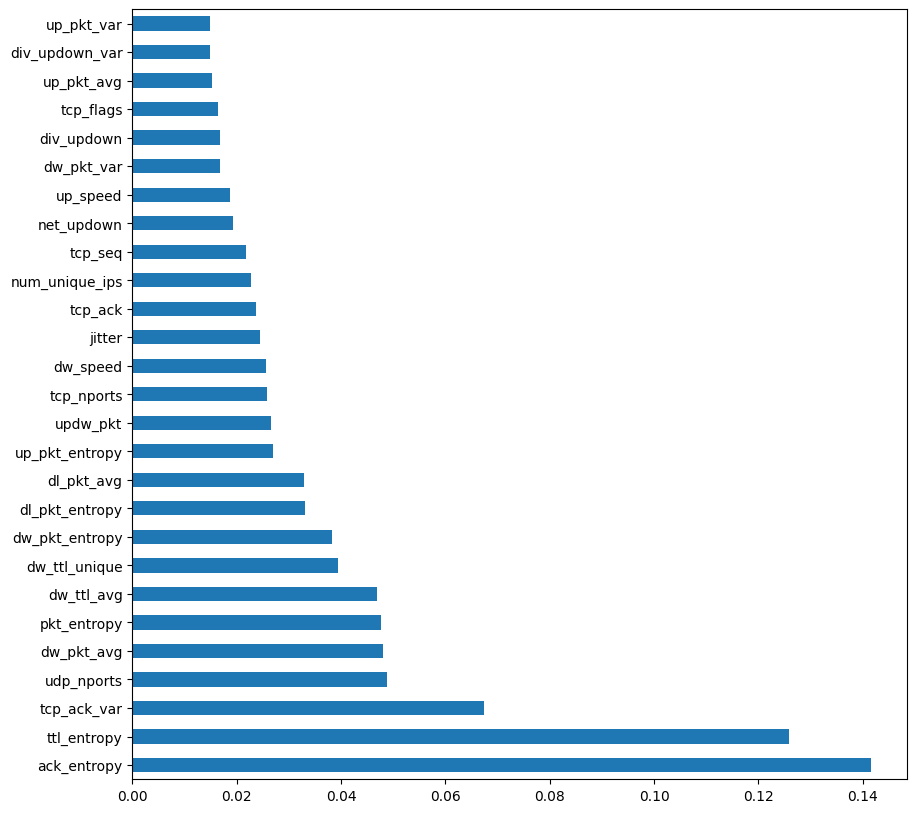

In [85]:
plt.figure(figsize=(10,10))
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances.plot(kind='barh')

In [70]:
feature_importances.index[:10].to_list()

['ack_entropy',
 'ttl_entropy',
 'tcp_ack_var',
 'udp_nports',
 'pkt_entropy',
 'dw_pkt_avg',
 'dw_ttl_avg',
 'dw_ttl_unique',
 'dw_pkt_entropy',
 'dl_pkt_avg']

<Axes: >

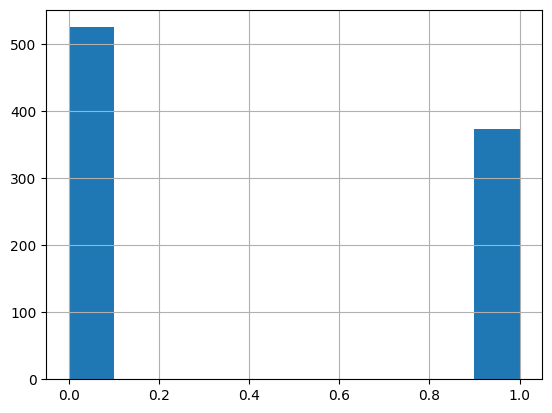

In [27]:
Xy.y.hist()

In [82]:
np.percentile(np.array(scores), [5, 10, 50, 90]) # 95% time its above 91% acuracy x

array([90.55555556, 91.61111111, 93.88888889, 96.11111111])

In [77]:
import joblib

In [83]:
joblib.dump(etree, 'etree.joblib')

['etree.joblib']